In [60]:
%reload_ext autoreload
%autoreload 2
import os
os.environ["THEANO_FLAGS"] = "device=gpu0"
#os.environ["CPATH"] = "/home/gridcl/mehdicherti/build/cuda/include/"
#os.environ["LIBRARY_PATH"] = "/home/gridcl/mehdicherti/build/cuda/lib64/"

import numpy as np
import cPickle as pickle
%matplotlib inline

import scipy.ndimage as nd
from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer

from lasagne import layers, updates

from IPython.display import SVG

import theano
import theano.tensor as T

from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

from theano.sandbox import rng_mrg



In [2]:

import PIL

from cStringIO import StringIO
import PIL.Image
from IPython.display import clear_output, Image, display

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def preprocess(mv, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - mv
def deprocess(mv, img):
    return np.dstack((img + mv)[::-1])

In [3]:
import vgg19, googlenet

model_name = "googlenet"

if model_name == "vgg":
    build_model = vgg19.build_model
    model_filename = "vgg19.pkl"
elif model_name == "googlenet":
    build_model = googlenet.build_model
    model_filename = "blvc_googlenet.pkl"

In [4]:
# build ggl net and load weights
net = build_model()
model_data = pickle.load(open(model_filename))
values = model_data['param values']
layers.set_all_param_values(net['prob'], values)

In [5]:
print(net.keys())

['input', 'conv1/7x7_s2', 'pool1/3x3_s2', 'pool1/norm1', 'conv2/3x3_reduce', 'conv2/3x3', 'conv2/norm2', 'pool2/3x3_s2', 'inception_3a/3x3_reduce', 'inception_3a/output', 'inception_3a/5x5_reduce', 'inception_3a/5x5', 'inception_3a/1x1', 'inception_3a/pool', 'inception_3a/pool_proj', 'inception_3a/3x3', 'inception_3b/3x3_reduce', 'inception_3b/pool', 'inception_3b/3x3', 'inception_3b/1x1', 'inception_3b/pool_proj', 'inception_3b/output', 'inception_3b/5x5_reduce', 'inception_3b/5x5', 'pool3/3x3_s2', 'inception_4a/3x3', 'inception_4a/3x3_reduce', 'inception_4a/pool', 'inception_4a/output', 'inception_4a/5x5', 'inception_4a/1x1', 'inception_4a/pool_proj', 'inception_4a/5x5_reduce', 'inception_4b/pool', 'inception_4b/1x1', 'inception_4b/5x5', 'inception_4b/pool_proj', 'inception_4b/5x5_reduce', 'inception_4b/output', 'inception_4b/3x3', 'inception_4b/3x3_reduce', 'inception_4c/1x1', 'inception_4c/5x5_reduce', 'inception_4c/pool_proj', 'inception_4c/3x3', 'inception_4c/pool', 'inception_4c

In [6]:
model = net
classes = np.array(model_data["synset words"])

if "mean value" in model_data:
    mean_value = (model_data["mean value"])
else:
    mean_value = np.array([104.0, 116.0, 122.0])

mean_value = mean_value[:, np.newaxis, np.newaxis]

In [7]:
draw_to_file(layers.get_all_layers(model['prob']), "{0}.svg".format(model_name))

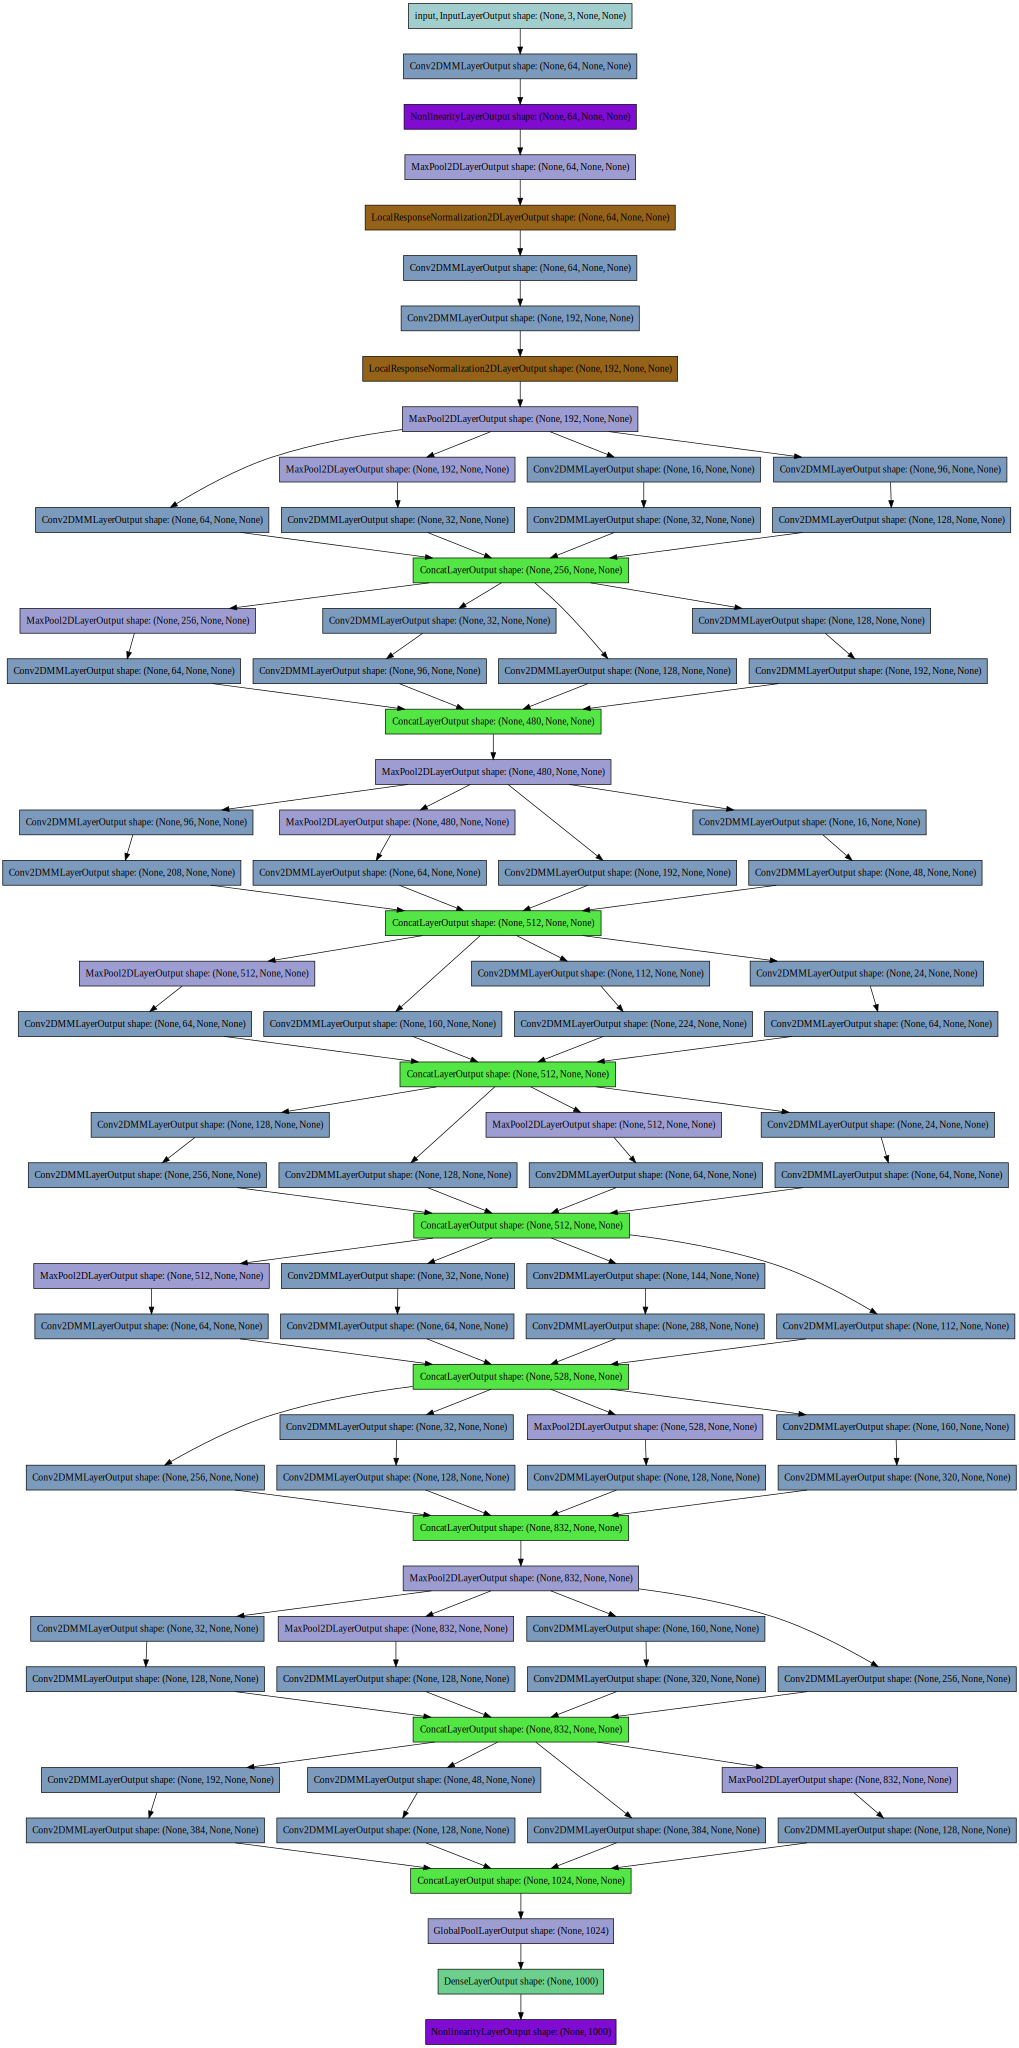

In [9]:
SVG("{0}.svg".format(model_name))

In [90]:
X_batch = theano.tensor.tensor4()
predict = theano.function([X_batch], layers.get_output(model["prob"], X_batch))
pre_predict = theano.function([X_batch], layers.get_output(model["prob"], X_batch))

In [74]:
!wget http://www.dph.am/sky1024px.jpg --output-document=sample.png
!wget http://i.ytimg.com/vi/s9dbAfjlrks/maxresdefault.jpg --output-document=sample2.png
!wget http://vienna-wv.com/images/tree.jpg --output-document=sample3.png
!wget http://img0.gtsstatic.com/wallpapers/214c7e23cc6330b95f9e395525bfb362_large.jpeg --output-document=sample4.png

--2015-09-14 13:19:37--  http://www.dph.am/sky1024px.jpg
Resolving www.dph.am... 198.244.107.6
Connecting to www.dph.am|198.244.107.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57024 (56K) [image/jpeg]
Saving to: “sample.png”

100%[======================================>] 57,024       111K/s   in 0.5s    

2015-09-14 13:19:37 (111 KB/s) - “sample.png” saved [57024/57024]

--2015-09-14 13:19:38--  http://i.ytimg.com/vi/s9dbAfjlrks/maxresdefault.jpg
Resolving i.ytimg.com... 173.194.40.133, 173.194.40.134, 173.194.40.135, ...
Connecting to i.ytimg.com|173.194.40.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142163 (139K) [image/jpeg]
Saving to: “sample2.png”

100%[======================================>] 142,163     --.-K/s   in 0.01s   

2015-09-14 13:19:38 (11.5 MB/s) - “sample2.png” saved [142163/142163]

--2015-09-14 13:19:38--  http://vienna-wv.com/images/tree.jpg
Resolving vienna-wv.com... 184.168.230.5
Connecting to vienn

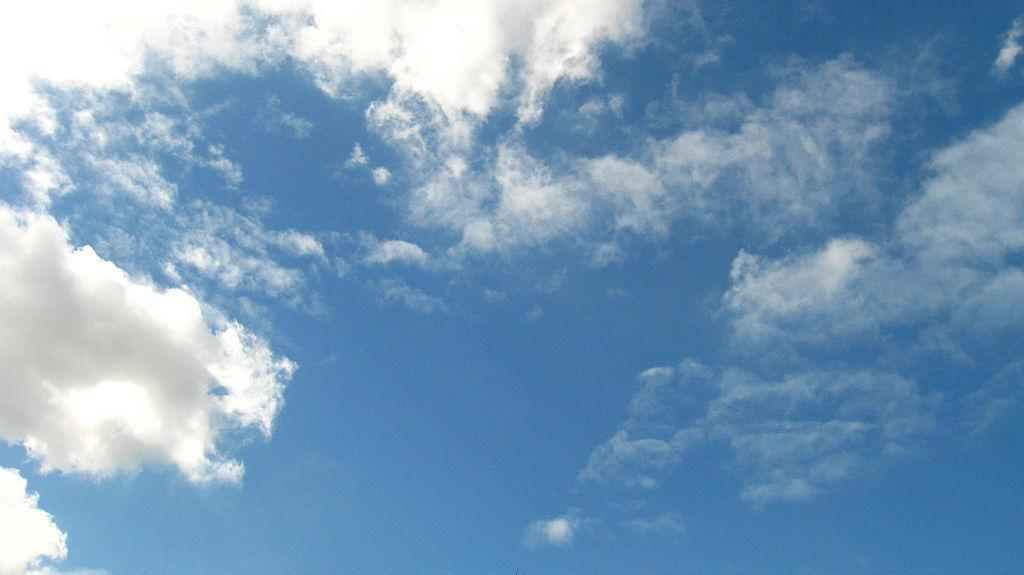

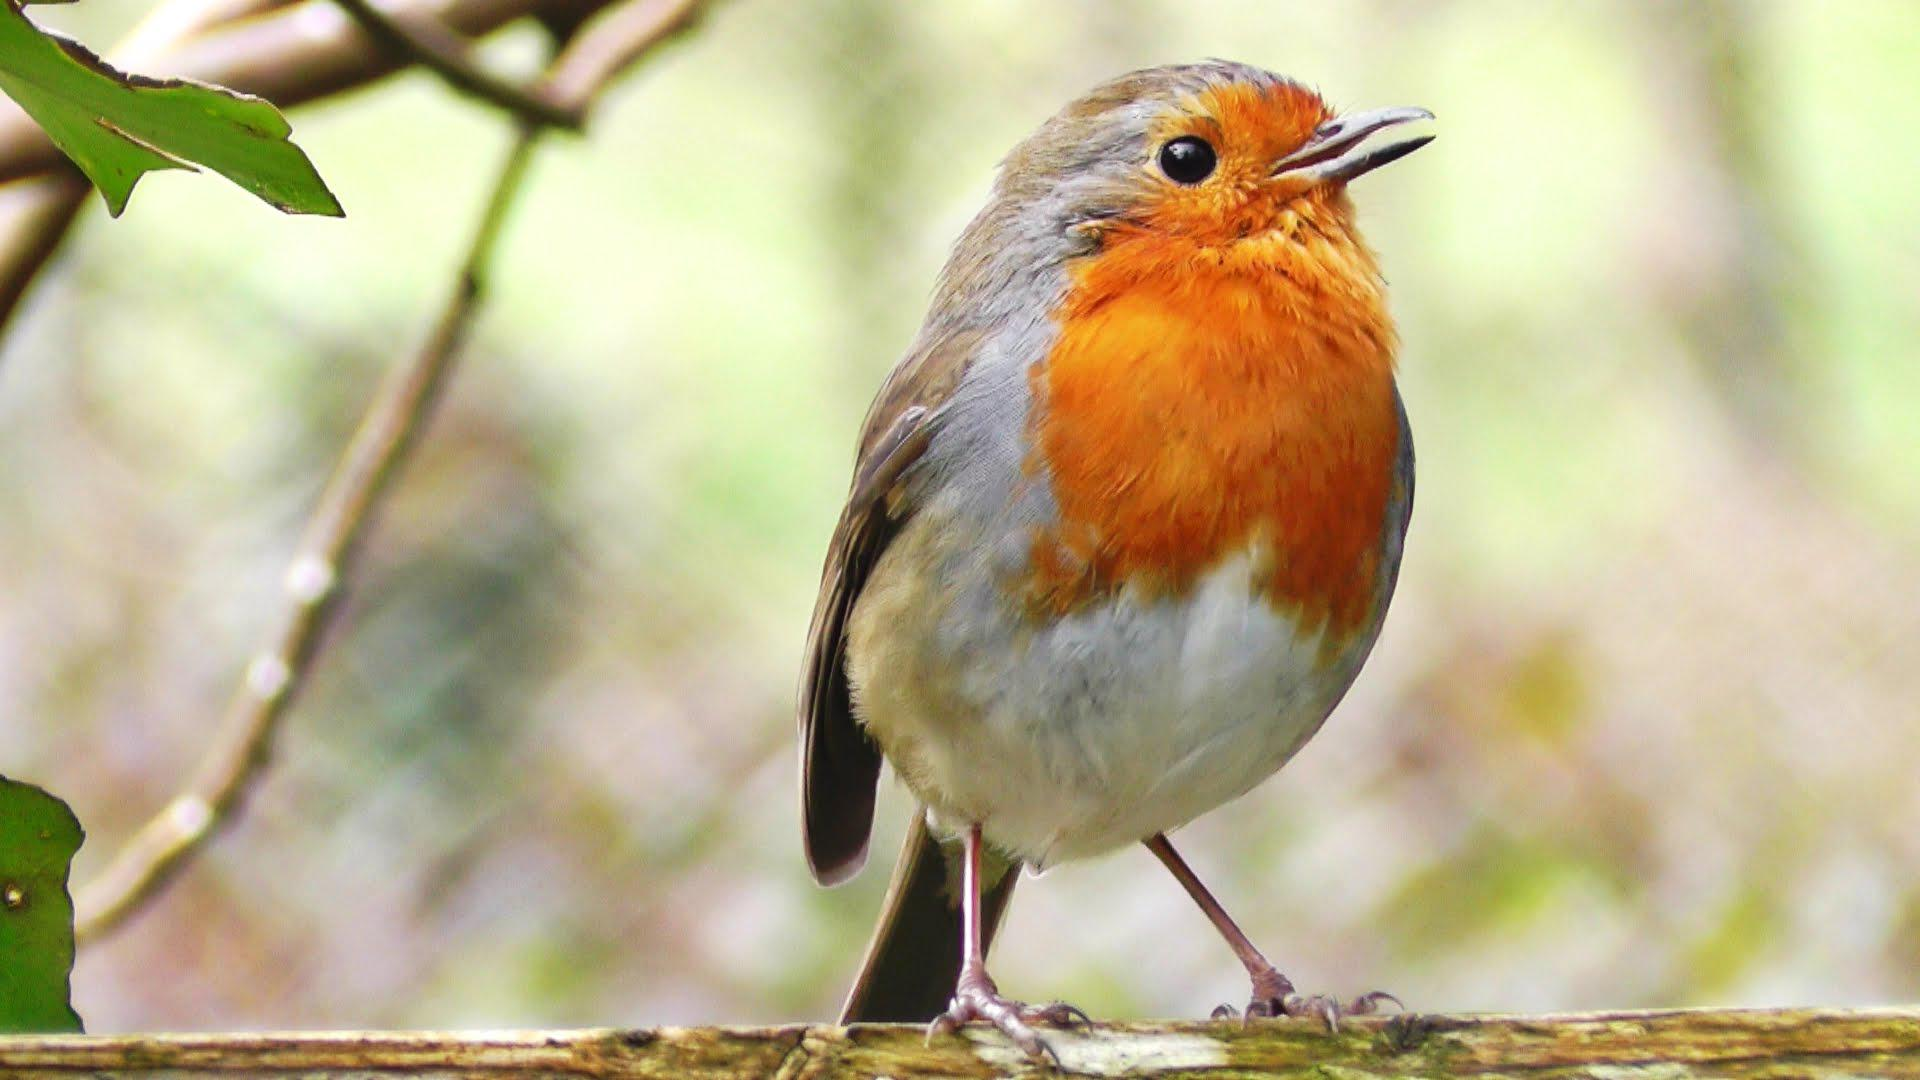

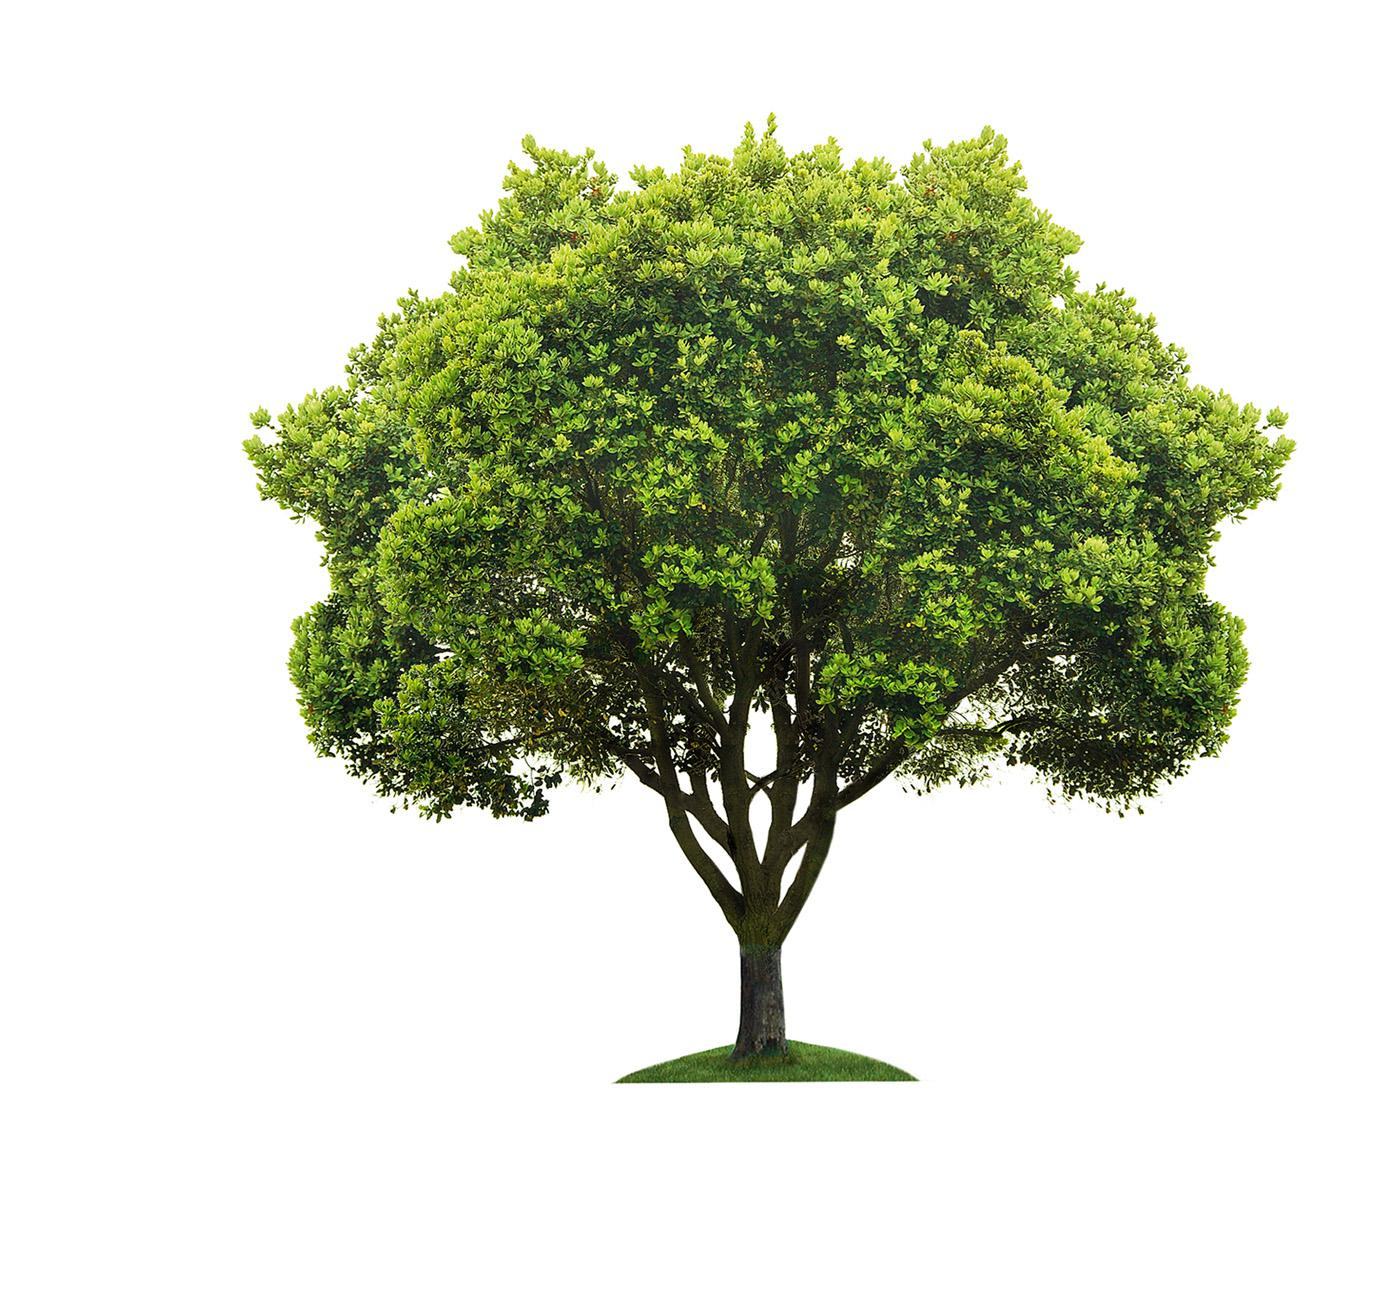

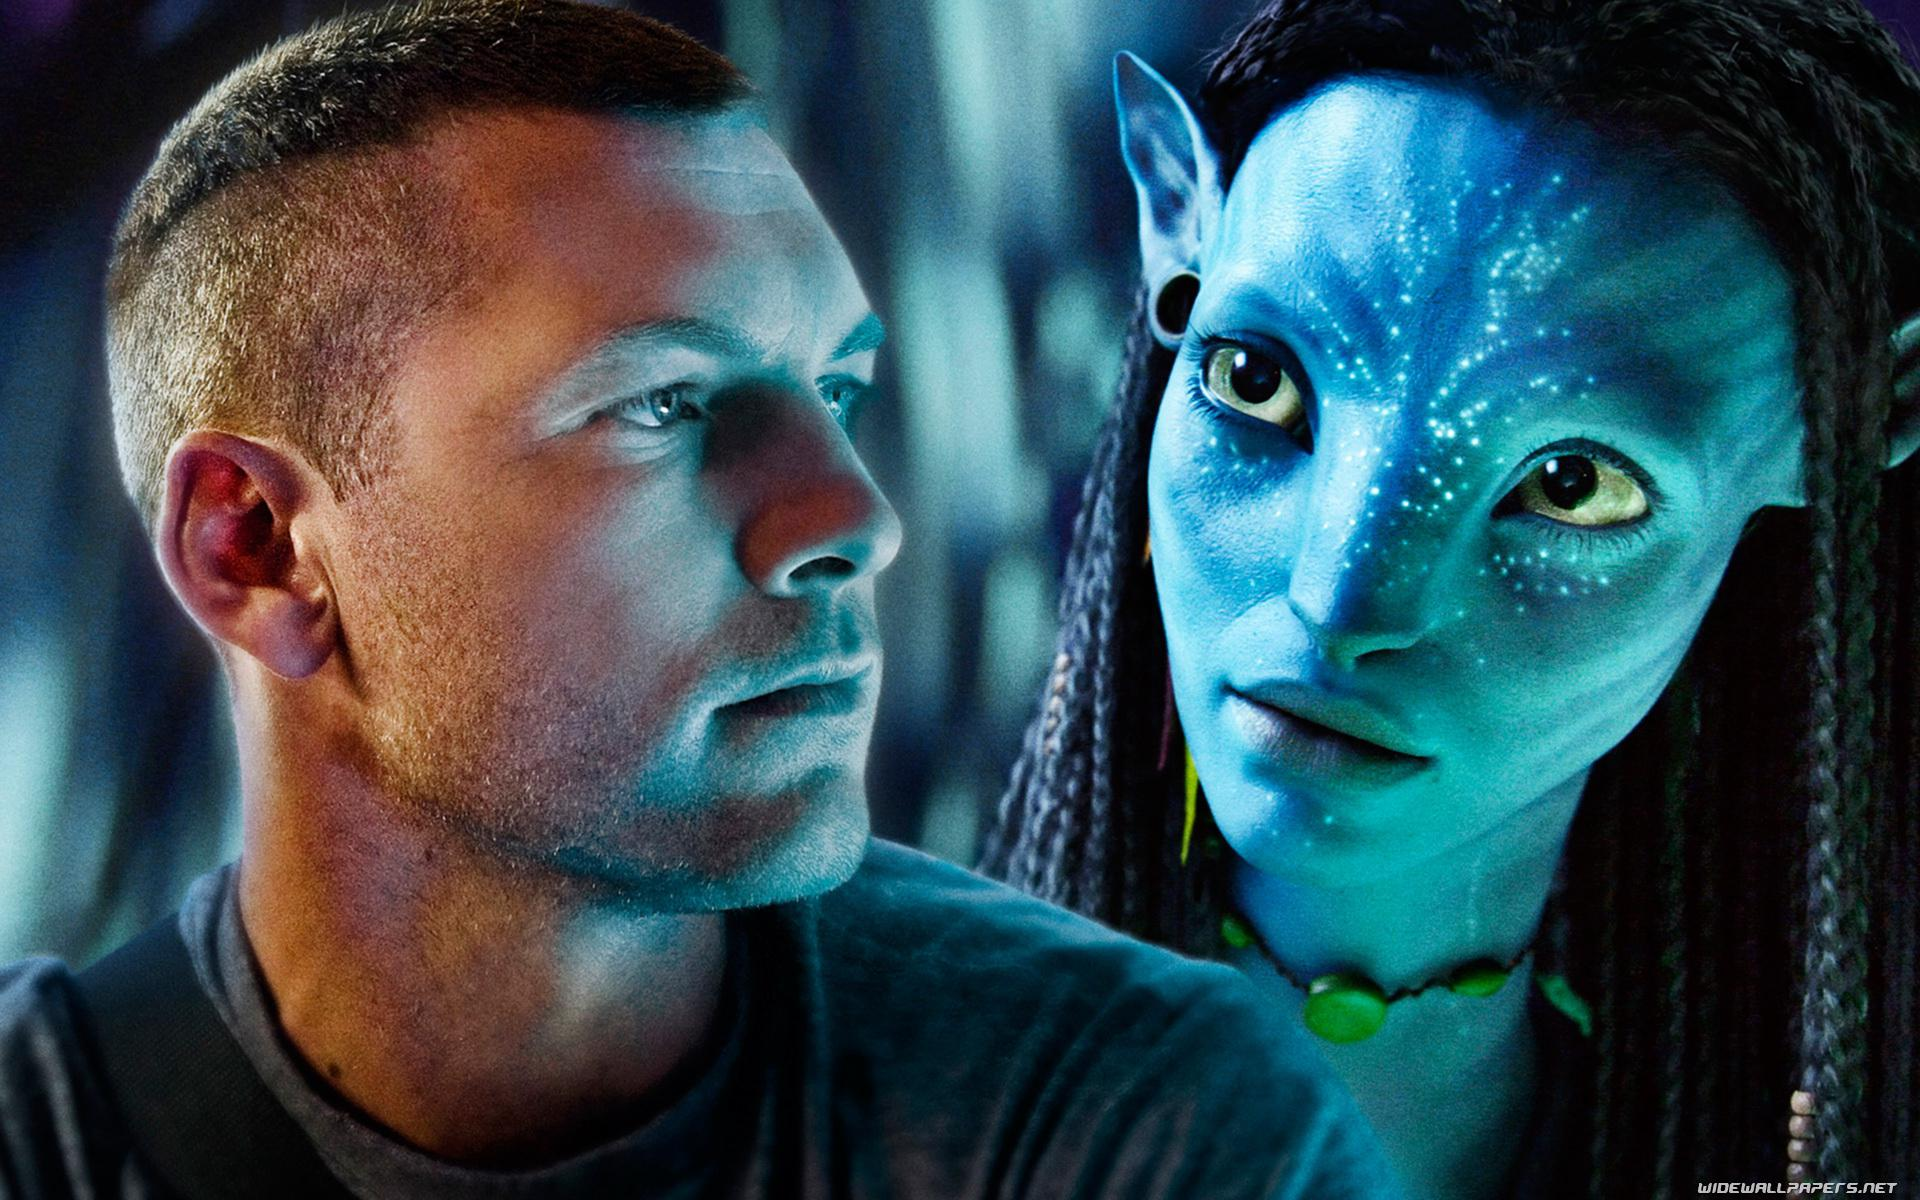

In [76]:
img_natural = np.float32(PIL.Image.open('sample.png'))
showarray(img_natural)
img_natural = np.float32(PIL.Image.open('sample2.png'))
showarray(img_natural)
img_natural = np.float32(PIL.Image.open('sample3.png'))
showarray(img_natural)
img_natural = np.float32(PIL.Image.open('sample4.png'))
showarray(img_natural)

In [77]:
print(model.keys())

['input', 'conv1/7x7_s2', 'pool1/3x3_s2', 'pool1/norm1', 'conv2/3x3_reduce', 'conv2/3x3', 'conv2/norm2', 'pool2/3x3_s2', 'inception_3a/3x3_reduce', 'inception_3a/output', 'inception_3a/5x5_reduce', 'inception_3a/5x5', 'inception_3a/1x1', 'inception_3a/pool', 'inception_3a/pool_proj', 'inception_3a/3x3', 'inception_3b/3x3_reduce', 'inception_3b/pool', 'inception_3b/3x3', 'inception_3b/1x1', 'inception_3b/pool_proj', 'inception_3b/output', 'inception_3b/5x5_reduce', 'inception_3b/5x5', 'pool3/3x3_s2', 'inception_4a/3x3', 'inception_4a/3x3_reduce', 'inception_4a/pool', 'inception_4a/output', 'inception_4a/5x5', 'inception_4a/1x1', 'inception_4a/pool_proj', 'inception_4a/5x5_reduce', 'inception_4b/pool', 'inception_4b/1x1', 'inception_4b/5x5', 'inception_4b/pool_proj', 'inception_4b/5x5_reduce', 'inception_4b/output', 'inception_4b/3x3', 'inception_4b/3x3_reduce', 'inception_4c/1x1', 'inception_4c/5x5_reduce', 'inception_4c/pool_proj', 'inception_4c/3x3', 'inception_4c/pool', 'inception_4c

In [8]:
if model_name == "googlenet":
    end = "inception_3a/1x1"
elif model_name == "vgg":
    end = "fc8"
o = layers.get_output(model[end], X_batch)

#L = 0.5*((o**2).sum())

L = (o[0, 10:100]**2).sum()

#L = layers.get_output(model["inception_3b/5x5_reduce"], X_batch)[0, 10]

get_grad = theano.function([X_batch], theano.grad(L, X_batch))


get_loss =  theano.function([X_batch], L)
get_forward = theano.function([X_batch], layers.get_output(model[end], X_batch))

NameError: name 'X_batch' is not defined

In [249]:
np.random.seed(5)
#img = np.random.uniform(0, 255, size=img_natural.shape)
img = img_natural.copy()


X = preprocess(mean_value, img).astype(np.float32)

if model_name == "googlenet":
    octave_scale = 1.4
    for i in range(3):
        X=(nd.zoom(X, (1, 1.0/octave_scale,1.0/octave_scale), order=1))
elif model_name == "vgg":
    X = resize(X, (3, 224, 224), preserve_range=True).astype(np.float32)

X = X[np.newaxis, :, :, :]


In [250]:
alpha = 0.01
curve = []
X_gen = X.copy()
l = None
for i in range(500):
    g = get_grad(X_gen)
    v = get_forward(X_gen)
    #X_gen += (alpha/ (np.abs(g).mean())) * g 
    X_gen += alpha * g
    #X_gen += nd.filters.gaussian_filter(X_gen, 1) * 0.001
    #X_gen += np.random.uniform(0, 0.1, size=X_gen.shape)
    #X_gen *= np.random.uniform(size=X_gen.shape)
    #X_gen += alpha * (g - 0.001 * 0.5 * X_gen)
    #X_gen = (1 - 0.001) * (X_gen + alpha * g)
    prev_l = l
    l = get_loss(X_gen)*2
    
    #if prev_l is not None and  l <= prev_l:
    #    alpha /= 2
    curve.append(l)
    if i % 10==0:
        print(l)

397.546508789
398.181274414
398.798583984
399.417785645
400.0362854
400.650512695
401.265014648
401.878356934
402.490570068
403.109680176
403.737365723


KeyboardInterrupt: 

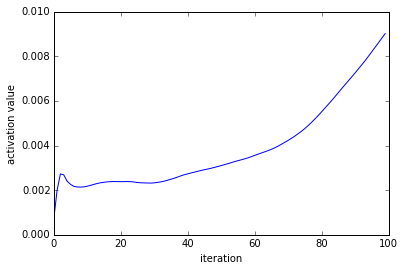

In [229]:
plt.xlabel("iteration")
plt.ylabel("activation value")
plt.plot(curve)

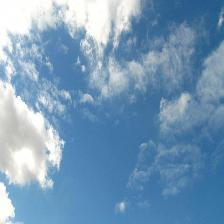

In [251]:
out = X_gen.copy()[0]
out = deprocess(mean_value, out)
showarray(out[:, :, :])

In [180]:
print(model.keysys())

['input', 'conv1/7x7_s2', 'pool1/3x3_s2', 'pool1/norm1', 'conv2/3x3_reduce', 'conv2/3x3', 'conv2/norm2', 'pool2/3x3_s2', 'inception_3a/3x3_reduce', 'inception_3a/output', 'inception_3a/5x5_reduce', 'inception_3a/5x5', 'inception_3a/1x1', 'inception_3a/pool', 'inception_3a/pool_proj', 'inception_3a/3x3', 'inception_3b/3x3_reduce', 'inception_3b/pool', 'inception_3b/3x3', 'inception_3b/1x1', 'inception_3b/pool_proj', 'inception_3b/output', 'inception_3b/5x5_reduce', 'inception_3b/5x5', 'pool3/3x3_s2', 'inception_4a/3x3', 'inception_4a/3x3_reduce', 'inception_4a/pool', 'inception_4a/output', 'inception_4a/5x5', 'inception_4a/1x1', 'inception_4a/pool_proj', 'inception_4a/5x5_reduce', 'inception_4b/pool', 'inception_4b/1x1', 'inception_4b/5x5', 'inception_4b/pool_proj', 'inception_4b/5x5_reduce', 'inception_4b/output', 'inception_4b/3x3', 'inception_4b/3x3_reduce', 'inception_4c/1x1', 'inception_4c/5x5_reduce', 'inception_4c/pool_proj', 'inception_4c/3x3', 'inception_4c/pool', 'inception_4c

In [20]:
print(layers.get_output_shape(model["inception_4c/output"]))

(None, 512, None, None)


##MultiDeepDream

In [119]:
t_generated_image = T.tensor4()
t_input_images = T.tensor4()

if model_name == "googlenet":
    #end_layers = ["inception_3a/1x1"]
    #end_layers = ['conv1/7x7_s2', 'conv2/3x3', 
    #              'inception_3a/output',  
    #              'inception_3b/output', 
    #              'inception_4a/output', 
    ##              'inception_4b/output', 
    #              'inception_4c/output']
    end_layers = [
        'inception_5b/3x3', 
        'inception_5b/3x3_reduce', 
        'inception_5b/pool', 
        'inception_5b/output', 
        'inception_5b/5x5', 
        'inception_5b/1x1', 
        'inception_5b/pool_proj'
    ]
elif model_name == "vgg":
    end_layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

L = 0

from theano.tensor.shared_randomstreams import RandomStreams

rng = rng_mrg.MRG_RandomStreams(seed=1234)


      
for layer_name in end_layers:
    o_input_images = layers.get_output(model[layer_name], t_input_images).reshape((len(images), -1))
    o_generated_image = layers.get_output(model[layer_name], t_generated_image).reshape((1, -1))
    
    
    nb_features = o_input_images.shape[1]
    #F = rng.random_integers(low=0, high=len(images)-1, size=(nb_features,))
    F = T.round(rng.uniform(low=0, high=len(images) - 1, size=(nb_features,)))
    F = F.astype('int32')
    desired_features = o_input_images[F, T.arange(nb_features)]
    actual_features = o_generated_image

    
    L += 0.5 * ((desired_features - actual_features)**2).sum()

L += -(layers.get_output(model["prob"], t_generated_image)**2).sum()



In [166]:
get_grad = theano.function([t_input_images, t_generated_image], theano.grad(L, t_generated_image), no_default_updates=True)
get_loss =  theano.function([t_input_images, t_generated_image], L, no_default_updates=True)

In [157]:
images = [
    np.float32(PIL.Image.open('sample.png')),
    np.float32(PIL.Image.open('sample3.png')),
#    np.float32(PIL.Image.open('sample3.png')),
]

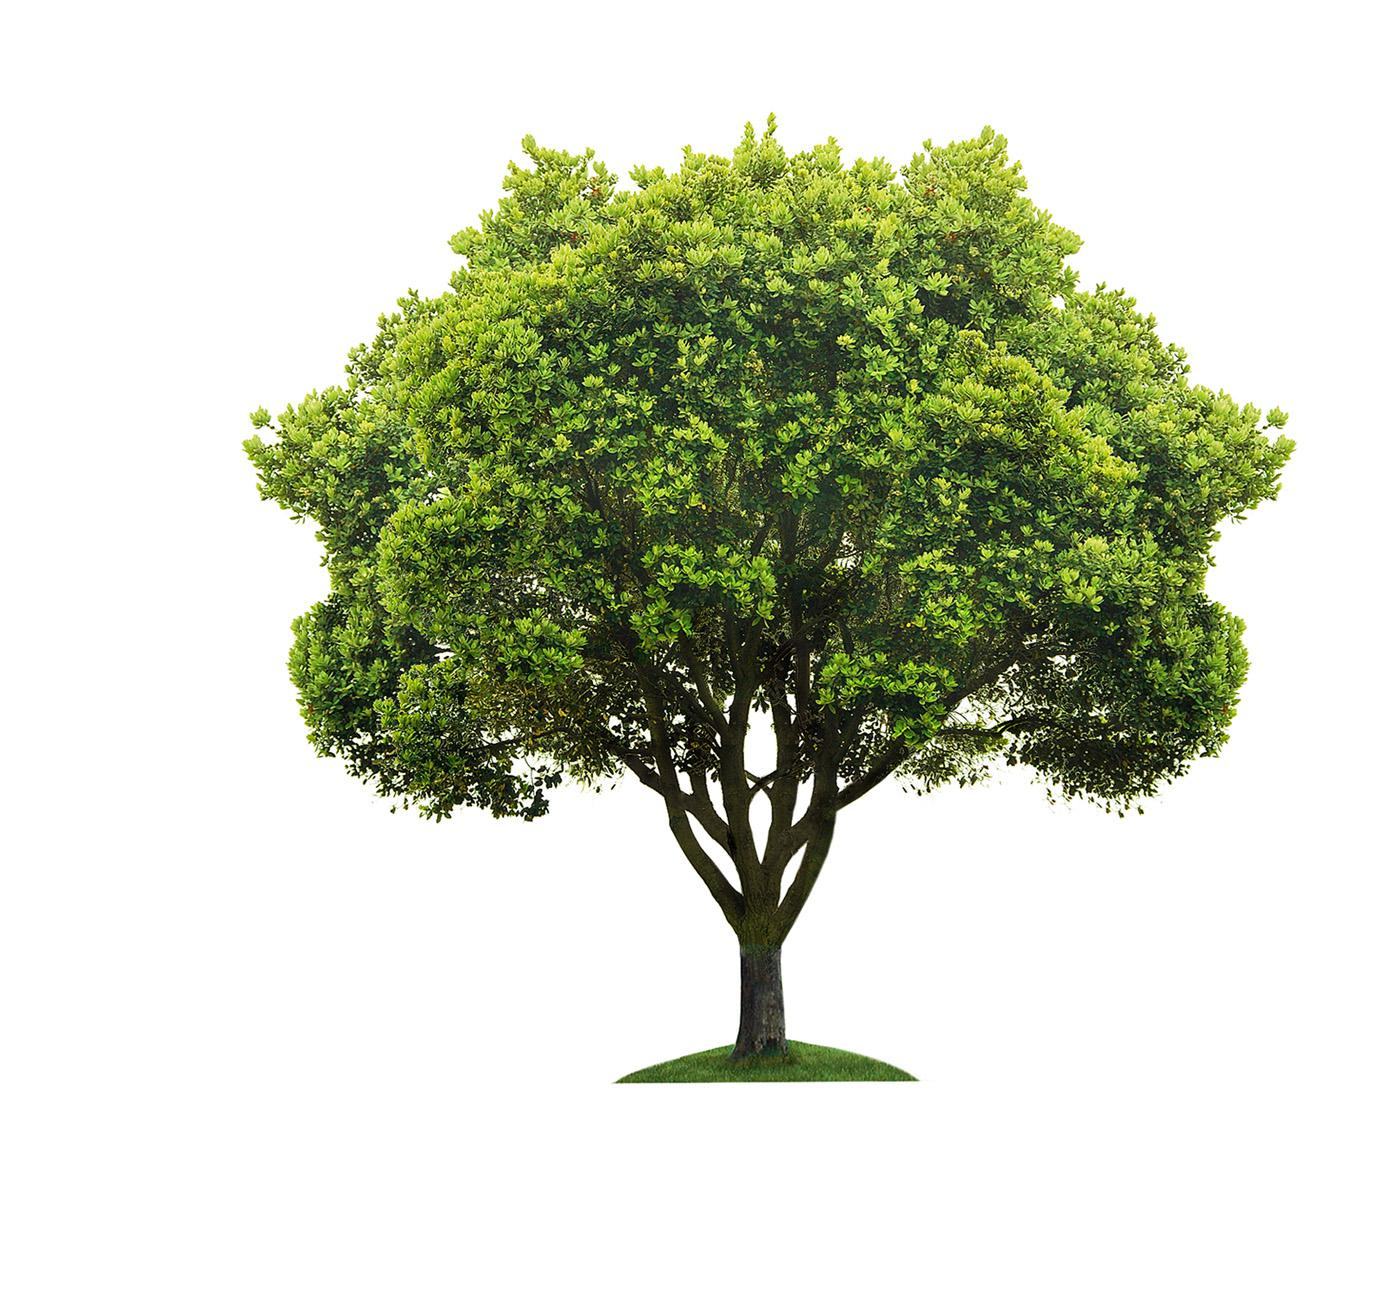

In [158]:
showarray(PIL.Image.open('sample3.png'))

In [159]:
h, w = 200, 300

In [160]:
generated_image = np.random.uniform(0, 255, size=images[0].shape)
generated_image = preprocess(mean_value, generated_image).astype(np.float32)
generated_image = resize(generated_image, (3, h, w), preserve_range=True).astype(np.float32)
generated_image = generated_image[np.newaxis, :, :, :]

In [161]:
images = [preprocess(mean_value, image).astype(np.float32) for image in images]

In [162]:
images = [resize(image, (3, h, w), preserve_range=True).astype(np.float32) for image in images]

In [163]:
mean_image = np.zeros(images[0].shape)
for im in images:
    mean_image += im
mean_image /= len(images)
mean_image = mean_image.astype(np.float32)

initialize_with_mean = False
if initialize_with_mean is True:
    generated_image = mean_image[np.newaxis, :, :, :]

In [164]:
input_images = np.array(images)

In [165]:
l = get_loss(input_images, generated_image)

In [152]:
print(images[0].shape, mean_image.shape)

((3, 200, 300), (3, 200, 300))


518865.5
(200, 300, 3)


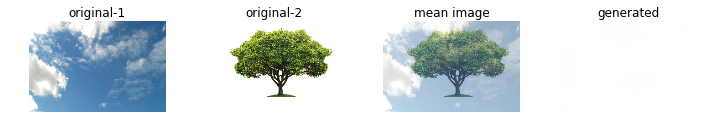

518835.03125
518807.09375
518781.21875
518755.65625
518729.59375
518703.375
518675.53125
518646.40625
518615.21875
518583.4375
(200, 300, 3)


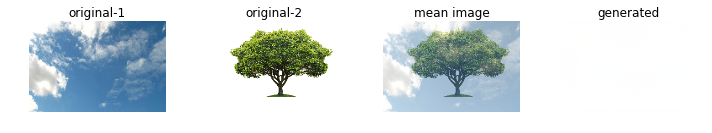

518550.78125
518516.4375
518481.0


KeyboardInterrupt: 

In [154]:
alpha = 0.001
generated_image_ = generated_image.copy()
curve = []

#jitter = 32

l = None
for i in range(1000):
    
    #ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    #g = get_grad(input_images,  np.roll(np.roll(generated_image_, ox, -1), oy, -2)) # apply jitter shift
    g = get_grad(input_images, generated_image_)

    generated_image_ -= alpha * g
    
    #generated_image_ = (1 - 0.001) * (generated_image_ - alpha * g)
    
    l = get_loss(input_images, generated_image_)
    curve.append(l)
    if i % 10==0:
        print(l)
    if i % 100==0:
        fig = plt.figure(figsize=(10, 10))

        im = images[0]
        plt.subplot(1, 4, 1)
        out = deprocess(mean_value, images[0])
        out = np.uint8(np.clip(out, 0, 255))
        plt.title("original-1")
        plt.axis('off')
        print(out.shape)
        plt.imshow(out)
        
        plt.subplot(1, 4, 2)
        out = deprocess(mean_value, images[1])
        out = np.uint8(np.clip(out, 0, 255))
        plt.title("original-2")
        plt.axis('off')
        plt.imshow(out)
        
        plt.subplot(1, 4, 3)
        out = deprocess(mean_value, mean_image)
        out = np.uint8(np.clip(out, 0, 255))
        plt.title("mean image")
        plt.axis('off')
        plt.imshow(out)


        plt.subplot(1, 4, 4)
        out = deprocess(mean_value, generated_image_[0])
        out = np.uint8(np.clip(out, 0, 255))
        plt.title("generated")
        plt.imshow(out)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

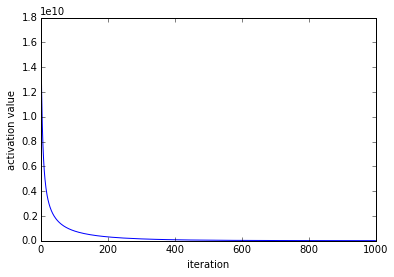

In [96]:
plt.xlabel("iteration")
plt.ylabel("activation value")
plt.plot(curve)

In [ ]:

print("original")

out = images[0]
out = deprocess(mean_value, out)
showarray(out[:, :, :])

print("generated")
out = generated_image_.copy()[0]
out = deprocess(mean_value, out)
showarray(out[:, :, :])

